In [ ]:
# Import basic libraries
import dask.distributed as dsk
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

# Plotting libraries
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cmocean as cm
import matplotlib.pyplot as plt

# Start client
clnt = dsk.Client()
clnt

# Monthly averaged data

In [2]:
path_era5_monthly = '/g/data/rt52/era5/single-levels/monthly-averaged/'

In [3]:
# These are the directory names, concatonated on the path above
variables = ['2t', 'mtpr', '10u', '10v', 'msdrswrf', 'aluvp']

Open concatenated variables:

In [5]:
# data is an empty dictionary
data = {}
# loop for the list in variables 
for v in variables:
    print('Opening: '+v)
    # loop through all directories to find the data files required over multiple years
    listv = np.sort(glob.glob(path_era5_monthly+v+'/**/*.nc'))
    data[v] = xr.open_mfdataset(listv)
    print('Opened')

Opening: 2t
Opened
Opening: mtpr
Opened
Opening: 10u
Opened
Opening: 10v
Opened
Opening: msdrswrf
Opened
Opening: aluvp
Opened


In [10]:
# Rename 2t temperature to be consistent
data['2t'] = data['2t'].rename({'t2m':'2t'})

Calculate `wind` and `sns`

In [19]:
data['sns'] = xr.Dataset({'sns':(1 - data['aluvp']['aluvp'])*data['msdrswrf']['msdrswrf']})
# Calculate wind speed from zonal and meridional components
data['wind'] = xr.Dataset({'wind':np.sqrt(data['10u']['u10']**2+data['10v']['v10']**2).rename('wind')})

Extract the locations of interest from the csv file and put them in a dataarray:

In [6]:
df = pd.read_csv('/g/data/e14/jn8053/andy-pitman/islands_AUS_export.csv')
locations = df.to_xarray()
extracted_data = xr.Dataset(data_vars = {'ulm_ID':locations['ulm_ID'],'long':locations['long'],'lat':locations['lat']})

Get nearest gridpoint in ERA5 for all variables (except u10 and v10 from the list because we don't want them):

In [38]:
extracted_data

<xarray.Dataset>
Dimensions:    (index: 4109, time: 762)
Coordinates:
  * index      (index) int64 0 1 2 3 4 5 6 ... 4103 4104 4105 4106 4107 4108
  * time       (time) datetime64[ns] 1959-01-01 1959-02-01 ... 2022-06-01
Data variables:
    ulm_ID     (index) int64 840 1282 75593 75594 ... 85144 85145 85146 85147
    long       (index) float64 158.7 158.9 147.0 147.0 ... 145.3 145.5 145.5
    lat        (index) float64 -55.11 -54.63 -43.86 ... -14.65 -14.86 -14.75
    2t         (time, index) float32 dask.array<chunksize=(1, 4109), meta=np.ndarray>
    mtpr       (time, index) float32 dask.array<chunksize=(1, 4109), meta=np.ndarray>
    wind       (time, index) float32 dask.array<chunksize=(1, 4109), meta=np.ndarray>
    msdrswrf   (time, index) float32 dask.array<chunksize=(1, 4109), meta=np.ndarray>
    aluvp      (time, index) float32 dask.array<chunksize=(1, 4109), meta=np.ndarray>
    sns        (time, index) float32 dask.array<chunksize=(1, 4109), meta=np.ndarray>
    land_mask  (index) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0

In [21]:
for v in ['2t', 'mtpr', 'wind', 'msdrswrf', 'aluvp', 'sns']:
    for var_name in data[v].data_vars:
        ext = data[v][var_name].sel(longitude = extracted_data['long'], latitude = extracted_data['lat'], method = 'nearest')
        extracted_data[v] = xr.DataArray(ext, 
                                         dims = {'time', 'index'}, 
                                         coords = {'index':extracted_data['index'], 'time':data[v]['time']}).rename(v)

2022-10-17 12:08:26,511 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-10-17 12:08:27,164 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2022-10-17 12:08:27,616 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2022-10-17 12:08:28,275 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2022-10-17 12:08:28,769 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2022-10-17 12:08:29,249 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2022-10-17 12:08:29,792 - distributed.utils_perf - WARNING - full garbage collections took 49% CPU time recently (threshold: 10%)
2022-10-17 12:08:30,258 - distributed.utils_perf - WARNING - full garbage collections took

In [24]:
# Replace negative values in rainfall with 0
extracted_data['mtpr'] = xr.where(extracted_data['mtpr']<0, 0, extracted_data['mtpr'])

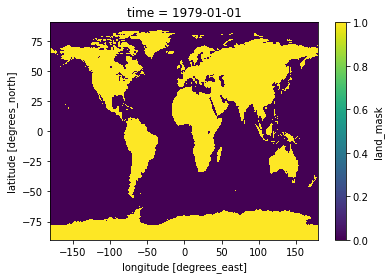

In [28]:
# Add land mask variable (1 == land, 0 == ocean). For this, we open a variable that we know is masked (in this case, wind)
# Open just one file, we don't care about time variations
mask = xr.open_dataset('/g/data/rt52/era5/single-levels/monthly-averaged/wind/1979/wind_era5_moda_sfc_19790101-19790131.nc')['wind']
mask = xr.where(np.isnan(mask), 1, 0).rename('land_mask')
mask.plot()

In [31]:
ext = mask.sel(longitude = extracted_data['long'], latitude = extracted_data['lat'], method = 'nearest')
extracted_data['land_mask'] = xr.DataArray(ext.squeeze(), 
                                           dims = {'index'}, 
                                           coords = {'index':extracted_data['index']})

In [32]:
# write out the data
# This data DOESN'T have Tmax, Tmin, or RH. Go to last section in this notebook for that.
extracted_data.to_netcdf('ERA5-monthly_averaged_NOmn2tmx2tRH.nc')

2022-10-17 12:10:48,344 - distributed.utils_perf - WARNING - full garbage collections took 49% CPU time recently (threshold: 10%)
2022-10-17 12:10:54,044 - distributed.utils_perf - WARNING - full garbage collections took 40% CPU time recently (threshold: 10%)
2022-10-17 12:11:03,783 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-10-17 12:11:41,763 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2022-10-17 12:11:46,503 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2022-10-17 12:11:47,842 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2022-10-17 12:11:49,036 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2022-10-17 12:13:14,610 - distributed.utils_perf - WARNING - full garbage collections took

# Preliminary monthly averaged data
Do the same but with the preliminary data from 1950 to 1959

In [39]:
path_era5_monthly = '/g/data/rt52/era5-preliminary/single-levels/monthly-averaged/'

In [40]:
# These are the directory names, concatonated on the path above
variables = ['2t', 'mtpr', '10u', '10v', 'msdrswrf', 'aluvp']

Open concatenated variables:

In [46]:
# data is an empty dictionary
data = {}
# loop for the list in variables 
for v in variables:
    print('Opening: '+v)
    # loop through all directories to find the data files required over multiple years
    listv = np.sort(glob.glob(path_era5_monthly+v+'/**/*.nc'))
    data[v] = xr.open_mfdataset(listv).sel(time = slice(None, '1958-12-31'))
    print('Opened')

Opening: 2t
Opened
Opening: mtpr
Opened
Opening: 10u
Opened
Opening: 10v
Opened
Opening: msdrswrf


2022-10-17 12:39:07,458 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Opened
Opening: aluvp
Opened


In [47]:
# Rename 2t temperature to be consistent
data['2t'] = data['2t'].rename({'t2m':'2t'})

Calculate `wind` and `sns`

In [48]:
data['sns'] = xr.Dataset({'sns':(1 - data['aluvp']['aluvp'])*data['msdrswrf']['msdrswrf']})
# Calculate wind speed from zonal and meridional components
data['wind'] = xr.Dataset({'wind':np.sqrt(data['10u']['u10']**2+data['10v']['v10']**2).rename('wind')})

Extract the locations of interest from the csv file and put them in a dataarray:

In [50]:
df = pd.read_csv('/g/data/e14/jn8053/andy-pitman/islands_AUS_export.csv')
locations = df.to_xarray()
extracted_data = xr.Dataset(data_vars = {'ulm_ID':locations['ulm_ID'],'long':locations['long'],'lat':locations['lat']})

Get nearest gridpoint in ERA5 for all variables (except u10 and v10 from the list because we don't want them):

In [52]:
for v in ['2t', 'mtpr', 'wind', 'msdrswrf', 'aluvp', 'sns']:
    for var_name in data[v].data_vars:
        ext = data[v][var_name].sel(longitude = extracted_data['long'], latitude = extracted_data['lat'], method = 'nearest')
        extracted_data[v] = xr.DataArray(ext, 
                                         dims = {'time', 'index'}, 
                                         coords = {'index':extracted_data['index'], 'time':data[v]['time']}).rename(v)

2022-10-17 12:39:29,334 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [53]:
# Replace negative values in rainfall with 0
extracted_data['mtpr'] = xr.where(extracted_data['mtpr']<0, 0, extracted_data['mtpr'])

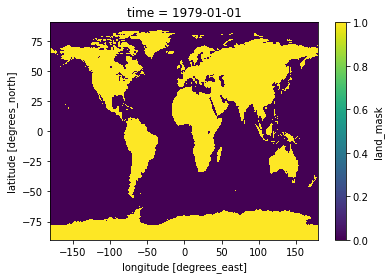

In [54]:
# Add land mask variable (1 == land, 0 == ocean). For this, we open a variable that we know is masked (in this case, wind)
# Open just one file, we don't care about time variations
mask = xr.open_dataset('/g/data/rt52/era5/single-levels/monthly-averaged/wind/1979/wind_era5_moda_sfc_19790101-19790131.nc')['wind']
mask = xr.where(np.isnan(mask), 1, 0).rename('land_mask')
mask.plot()

In [55]:
ext = mask.sel(longitude = extracted_data['long'], latitude = extracted_data['lat'], method = 'nearest')
extracted_data['land_mask'] = xr.DataArray(ext.squeeze(), 
                                           dims = {'index'}, 
                                           coords = {'index':extracted_data['index']})

In [56]:
# write out the data
# This data DOESN'T have Tmax, Tmin, or RH. Go to last section in this notebook for that.
extracted_data.to_netcdf('ERA5-prelim-monthly_averaged_NOmn2tmx2tRH.nc')

2022-10-17 12:39:41,031 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


## Make time-mean plots:

In [100]:
data = xr.open_mfdataset(['ERA5-monthly_averaged_NOmn2tmx2tRH.nc'])

In [101]:
# Make figure instance with Aus. maps
def australia_plot():
    # Projection
    albo = ccrs.AlbersEqualArea(central_latitude=0,
                                false_easting=0, 
                                false_northing=0, 
                                central_longitude=132, 
                                standard_parallels=(-18, -36))
    fig = plt.figure(figsize=(20,10))
    axs = [fig.add_subplot(231, projection=albo),
           fig.add_subplot(232, projection=albo),
           fig.add_subplot(233, projection=albo),
           fig.add_subplot(234, projection=albo),
           fig.add_subplot(235, projection=albo),
           fig.add_subplot(236, projection=albo)]
    for ax in axs:
        ax.set_extent([112, 156, -44, -7])
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                       edgecolor = 'black', facecolor = 'gainsboro'), zorder = 0)
        ax.gridlines()
    return fig, axs

In [103]:
lon, lat = data['long'], data['lat']

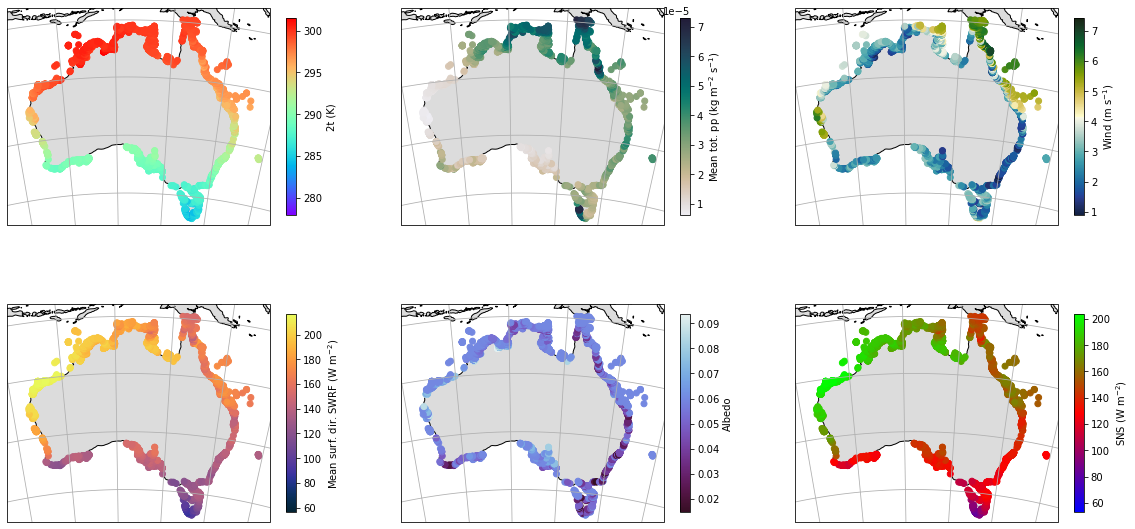

In [104]:
fig, axs = australia_plot();
p = axs[0].scatter(lon, lat, c = data['2t'].mean('time'), cmap = 'rainbow',  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[0], shrink = .8).set_label('2t (K)')
p = axs[1].scatter(lon, lat, c = data['mtpr'].mean('time'), cmap = cm.cm.rain,  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[1], shrink = .8).set_label('Mean tot. pp (kg m$^{-2}$ s$^{-1}$)')
p = axs[2].scatter(lon, lat, c = data['wind'].mean('time'), cmap = cm.cm.delta,  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[2], shrink = .8).set_label('Wind (m s$^{-1}$)')
p = axs[3].scatter(lon, lat, c = data['msdrswrf'].mean('time'), cmap = cm.cm.thermal,  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[3], shrink = .8).set_label('Mean surf. dir. SWRF (W m$^{-2}$)')
p = axs[4].scatter(lon, lat, c = data['aluvp'].mean('time'), cmap = cm.cm.dense_r,  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[4], shrink = .8).set_label('Albedo')
p = axs[5].scatter(lon, lat, c = data['sns'].mean('time'), cmap = 'brg',  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[5], shrink = .8).set_label('SNS (W m$^{-2}$)')

## Random time series

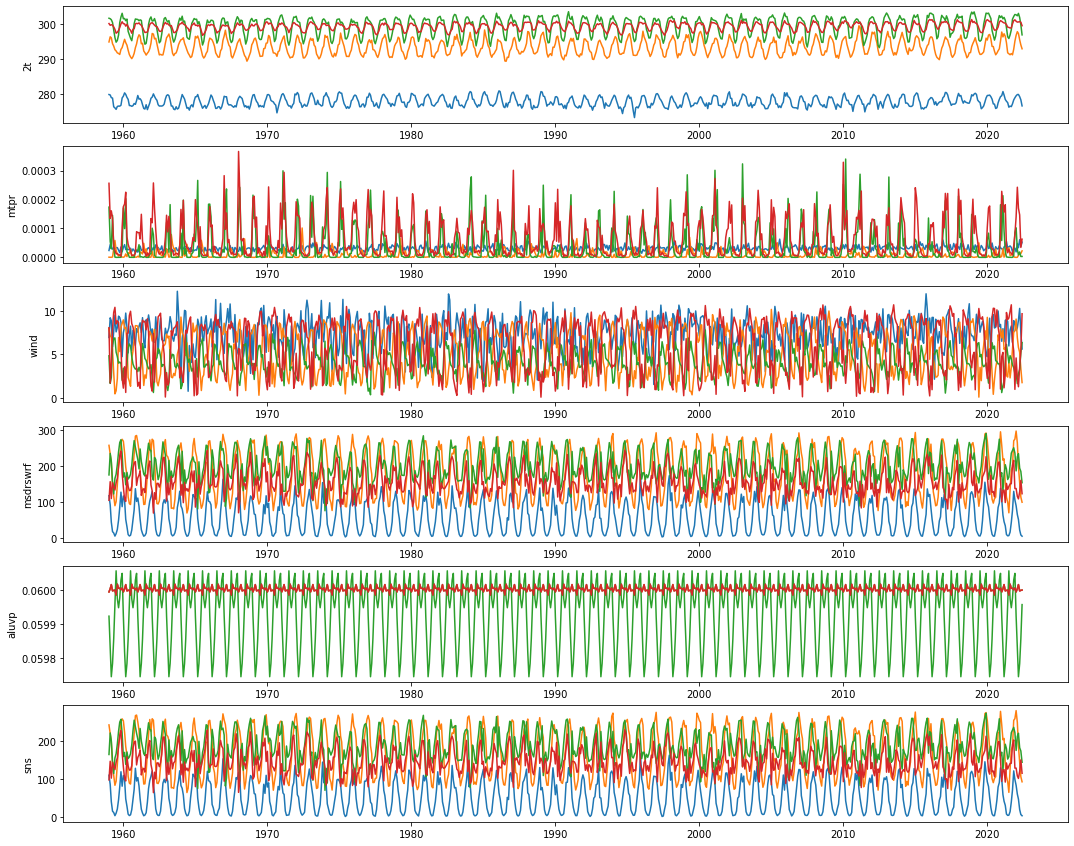

In [105]:
fig = plt.figure(figsize=(18,15))
axs = [fig.add_subplot(611),
       fig.add_subplot(612),
       fig.add_subplot(613),
       fig.add_subplot(614),
       fig.add_subplot(615),
       fig.add_subplot(616)]
n = 0
for v in ['2t', 'mtpr', 'wind', 'msdrswrf', 'aluvp', 'sns']:
    for i in [0, 1000, 3000, 4000]:
        axs[n].plot(data['time'], data[v].isel(index = i))
        axs[n].set_ylabel(v)
    n += 1

# Daily averaged data

In [106]:
df = pd.read_csv('/g/data/e14/jn8053/andy-pitman/islands_AUS_export.csv')
locations = df.to_xarray()
extracted_data = xr.Dataset(data_vars = {'ulm_ID':locations['ulm_ID'],'long':locations['long'],'lat':locations['lat']})

In [107]:
# Avoid loading globally, and resample from hourly to daily
def preprocessing(ds):
    # Preprocess to extract Australian domain to aid computational cost
    ds = ds.sel(longitude = slice(112, 156), latitude = slice(-7, -44))
    return ds

In [108]:
path_era5_daily = '/g/data/rt52/era5/single-levels/reanalysis/'

In [109]:
variables = ['mn2t', 'mx2t', '2t', '2d']

Open concatenated datasets:

In [110]:
data = {}
for v in variables:
    print('Opening: '+v)
    listv = np.sort(glob.glob(path_era5_daily+v+'/**/*.nc'))
    data[v] = xr.open_mfdataset(listv, preprocess = preprocessing)
    print('Opened')

Opening: mn2t
Opened
Opening: mx2t
Opened
Opening: 2t
Opened
Opening: 2d
Opened


Add the `mn2t` and `mx2t` extension:

In [111]:
path_extension = '/g/data/ua8/tmp-julia/'

In [115]:
np.sort(glob.glob(path_extension+'mn2t/**/*.nc'))

array([], dtype=float64)

In [112]:
data_ext = {}
for v in ['mn2t', 'mx2t']:
    print('Opening: '+v)
    listv = np.sort(glob.glob(path_extension+v+'/**/*.nc'))
    data_ext[v] = xr.open_mfdataset(listv, preprocess = preprocessing)
    print('Opened')

Opening: mn2t


OSError: no files to open

In [ ]:
for v in variables:
    for var_name in data[v].data_vars:
        ext = data[v][var_name].sel(longitude = extracted_data['long'], latitude = extracted_data['lat'], method = 'nearest')
        extracted_data[v] = xr.DataArray(ext, 
                                         dims = {'index', 'time'}, 
                                         coords = {'index':extracted_data['index'], 'time':data[v]['time']}).rename(v)

Saving takes time because it has to load into memory:

In [ ]:
extracted_data.to_netcdf('ERA5-daily_averaged.nc')

## Make time-mean plots:

In [125]:
data = xr.open_dataset('ERA5-daily_averaged.nc')

### Add relative humidity

$$RH = 100exp(\frac{cb(DP-T)}{(c+T)(c+DP)})$$

with b = 17.625 and c = 243.04

In [143]:
data['rh'] = xr.DataArray(100*np.exp(243.04*17.625*(data['2d'] - data['2t']) / ((243.04+data['2t'])*(243.04+data['2d']))), 
                          dims = {'index', 'time'}, 
                          coords = {'index':extracted_data['index'], 'time':data[v]['time']}).rename('rh')

In [144]:
data.to_netcdf('ERA5-daily_averaged.nc')

In [145]:
def australia_plot():
    # Projection
    albo = ccrs.AlbersEqualArea(central_latitude=0,
                                false_easting=0, 
                                false_northing=0, 
                                central_longitude=132, 
                                standard_parallels=(-18, -36))
    fig = plt.figure(figsize=(20,8))
    axs = [fig.add_subplot(241, projection=albo),
           fig.add_subplot(242, projection=albo),
           fig.add_subplot(243, projection=albo),
           fig.add_subplot(244, projection=albo),
           fig.add_subplot(245, projection=albo),
           fig.add_subplot(246, projection=albo),
           fig.add_subplot(247, projection=albo),
           fig.add_subplot(248, projection=albo)]
    for ax in axs:
        ax.set_extent([112, 156, -44, -7])
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                       edgecolor = 'black', facecolor = 'gainsboro'), zorder = 0)
        ax.gridlines()
    return fig, axs

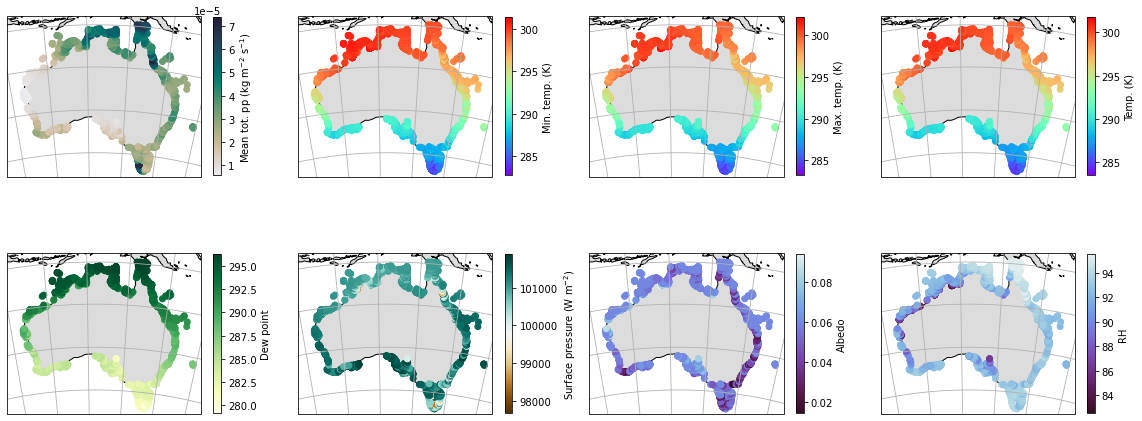

In [147]:
fig, axs = australia_plot();
p = axs[0].scatter(data['long'], data['lat'], c = data['mtpr'].mean('time'), cmap = cm.cm.rain,  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[0], shrink = .8).set_label('Mean tot. pp (kg m$^{-2}$ s$^{-1}$)')
p = axs[1].scatter(data['long'], data['lat'], c = data['mn2t'].mean('time'), cmap = 'rainbow',  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[1], shrink = .8).set_label('Min. temp. (K)')
p = axs[2].scatter(data['long'], data['lat'], c = data['mx2t'].mean('time'), cmap = 'rainbow',  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[2], shrink = .8).set_label('Max. temp. (K)')
p = axs[3].scatter(data['long'], data['lat'], c = data['2t'].mean('time'), cmap = 'rainbow',  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[3], shrink = .8).set_label('Temp. (K)')
p = axs[4].scatter(data['long'], data['lat'], c = data['2d'].mean('time'), cmap = 'YlGn',  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[4], shrink = .8).set_label('Dew point')
p = axs[5].scatter(data['long'], data['lat'], c = data['sp'].mean('time'), cmap = 'BrBG',  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[5], shrink = .8).set_label('Surface pressure (W m$^{-2}$)')
p = axs[6].scatter(data['long'], data['lat'], c = data['aluvp'].mean('time'), cmap = cm.cm.dense_r,  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[6], shrink = .8).set_label('Albedo')
p = axs[7].scatter(data['long'], data['lat'], c = data['rh'].mean('time'), cmap = cm.cm.dense_r,  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[7], shrink = .8).set_label('RH')

# Add Tmax, Tmin and RH to monthly data

In [3]:
data_monthly = xr.open_dataset('ERA5-monthly_averaged_new.nc')
data_daily = xr.open_dataset('ERA5-daily_averaged.nc')

In [40]:
tmax = data_daily['mx2t'].resample(time = '1M').mean('time')
data_monthly['mx2t'] = xr.DataArray(tmax.values)
data_monthly['mx2t'] = data_monthly['mx2t'].rename({'dim_0':'time', 'dim_1':'index'})
data_monthly['mx2t']

<xarray.DataArray 'mx2t' (time: 518, index: 4109)>
array([[287.732  , 287.732  , 287.81244, ..., 299.97037, 300.1231 ,
        300.1231 ],
       [287.48642, 287.48642, 287.89133, ..., 299.819  , 299.94553,
        299.94553],
       [286.68323, 286.68323, 287.73755, ..., 299.85382, 300.02307,
        300.02307],
       ...,
       [286.77652, 286.77652, 286.53763, ..., 301.1687 , 301.2188 ,
        301.2188 ],
       [288.5797 , 288.5797 , 288.87207, ..., 301.0311 , 301.13406,
        301.13406],
       [288.5668 , 288.5668 , 288.75406, ..., 300.9121 , 301.03174,
        301.03174]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-02-01
  * index    (index) int64 0 1 2 3 4 5 6 ... 4102 4103 4104 4105 4106 4107 4108

In [39]:
tmin = data_daily['mn2t'].resample(time = '1M').mean('time')
data_monthly['mn2t'] = xr.DataArray(tmin.values)
data_monthly['mn2t'] = data_monthly['mn2t'].rename({'dim_0':'time', 'dim_1':'index'})
data_monthly['mn2t']

<xarray.DataArray 'mn2t' (time: 518, index: 4109)>
array([[287.62625, 287.62625, 287.68588, ..., 299.7871 , 299.9619 ,
        299.9619 ],
       [287.36377, 287.36377, 287.75754, ..., 299.61792, 299.76773,
        299.76773],
       [286.59714, 286.59714, 287.61618, ..., 299.69897, 299.89117,
        299.89117],
       ...,
       [286.67636, 286.67636, 286.40833, ..., 301.02298, 301.09576,
        301.09576],
       [288.49234, 288.49234, 288.7805 , ..., 300.83658, 300.97495,
        300.97495],
       [288.45245, 288.45245, 288.61203, ..., 300.71866, 300.8637 ,
        300.8637 ]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-02-01
  * index    (index) int64 0 1 2 3 4 5 6 ... 4102 4103 4104 4105 4106 4107 4108

In [41]:
rh = data_daily['rh'].resample(time = '1M').mean('time')
data_monthly['rh'] = xr.DataArray(rh.values)
data_monthly['rh'] = data_monthly['rh'].rename({'dim_0':'time', 'dim_1':'index'})
data_monthly['rh']

<xarray.DataArray 'rh' (time: 518, index: 4109)>
array([[94.85419 , 94.85419 , 94.53911 , ..., 96.19871 , 96.0861  ,
        96.0861  ],
       [94.56526 , 94.56526 , 94.65545 , ..., 96.18075 , 96.11438 ,
        96.11438 ],
       [93.422966, 93.422966, 93.95706 , ..., 95.55364 , 95.362465,
        95.362465],
       ...,
       [93.515564, 93.515564, 92.974884, ..., 94.090935, 94.041756,
        94.041756],
       [94.75297 , 94.75297 , 95.02266 , ..., 95.521935, 95.42777 ,
        95.42777 ],
       [92.7639  , 92.7639  , 93.16534 , ..., 94.89904 , 94.80604 ,
        94.80604 ]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-02-01
  * index    (index) int64 0 1 2 3 4 5 6 ... 4102 4103 4104 4105 4106 4107 4108

In [70]:
data_monthly.to_netcdf('ERA5-monthly_averaged_complete.nc')

In [7]:
data_monthly = xr.open_dataset('ERA5-monthly_averaged_complete.nc')

In [72]:
# Make figure instance with Aus. maps
def australia_plot():
    # Projection
    albo = ccrs.AlbersEqualArea(central_latitude=0,
                                false_easting=0, 
                                false_northing=0, 
                                central_longitude=132, 
                                standard_parallels=(-18, -36))
    fig = plt.figure(figsize=(20,5))
    axs = [fig.add_subplot(131, projection=albo),
           fig.add_subplot(132, projection=albo),
           fig.add_subplot(133, projection=albo)]
    for ax in axs:
        ax.set_extent([112, 156, -44, -7])
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                       edgecolor = 'black', facecolor = 'gainsboro'), zorder = 0)
        ax.gridlines()
    return fig, axs

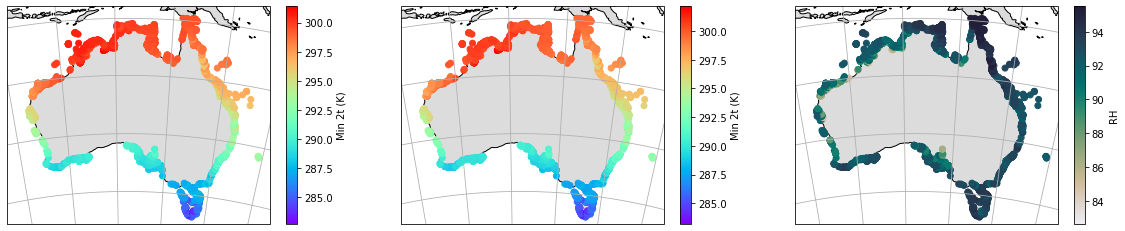

In [73]:
fig, axs = australia_plot();
p = axs[0].scatter(data_monthly['long'], data_monthly['lat'], c = data_monthly['mn2t'].mean('time'), cmap = 'rainbow',  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[0], shrink = .8).set_label('Min 2t (K)')
p = axs[1].scatter(data_monthly['long'], data_monthly['lat'], c = data_monthly['mx2t'].mean('time'), cmap = 'rainbow',  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[1], shrink = .8).set_label('Min 2t (K)')
p = axs[2].scatter(data_monthly['long'], data_monthly['lat'], c = data_monthly['rh'].mean('time'), cmap = cm.cm.rain,  
                   transform = ccrs.PlateCarree(), zorder = 1)
plt.colorbar(p, ax = axs[2], shrink = .8).set_label('RH')

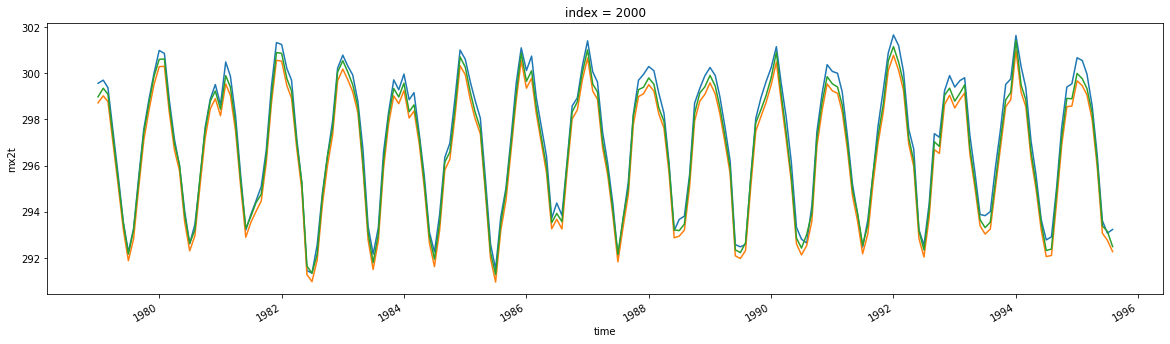

In [74]:
data_monthly['2t'].isel(index = 2000).isel(time=slice(0,200)).plot(figsize = (20,5), label = 'Mean T', add_legend = True)
data_monthly['mn2t'].isel(index = 2000).isel(time=slice(0,200)).plot(label = 'Min T')
data_monthly['mx2t'].isel(index = 2000).isel(time=slice(0,200)).plot(label = 'Max T')

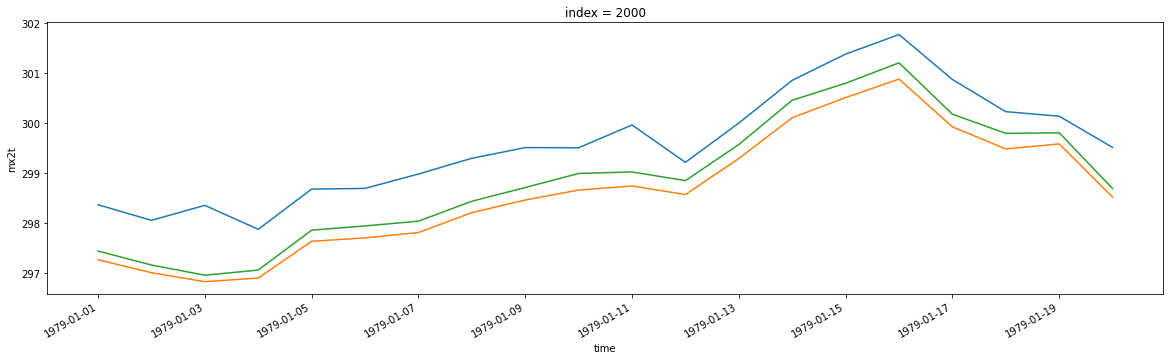

In [53]:
data_daily['2t'].isel(index = 2000).isel(time=slice(0,20)).plot(figsize = (20,5), label = 'Mean T', add_legend = True)
data_daily['mn2t'].isel(index = 2000).isel(time=slice(0,20)).plot(label = 'Min T')
data_daily['mx2t'].isel(index = 2000).isel(time=slice(0,20)).plot(label = 'Max T')

This is a bit strage. Check original 3h data

In [2]:
path_era5_daily = '/g/data/rt52/era5/single-levels/reanalysis/'

In [3]:
variables = ['mn2t', 'mx2t', '2t']

Open concatenated datasets:

In [4]:
data = {}
for v in variables:
    print('Opening: '+v)
    listv = np.sort(glob.glob(path_era5_daily+v+'/1979/*.nc'))
    data[v] = xr.open_mfdataset(listv)
    print('Opened')

Opening: mn2t
Opened
Opening: mx2t
Opened
Opening: 2t
Opened


In [58]:
data_monthly['long'].isel(index=2000)

<xarray.DataArray 'long' ()>
array(146.173039)
Coordinates:
    index    int64 2000

In [59]:
data_monthly['lat'].isel(index=2000)

<xarray.DataArray 'lat' ()>
array(-18.413722)
Coordinates:
    index    int64 2000

In [9]:
i=800

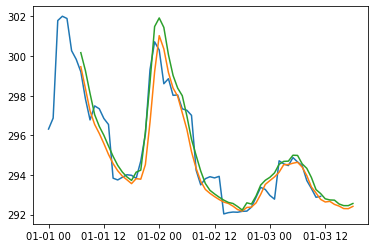

In [12]:
plt.plot(data['2t']['time'][0:60], data['2t'].sel(longitude = data_monthly['long'].isel(index=i).values, latitude = data_monthly['lat'].isel(index=i).values, 
               method = 'nearest').isel(time = slice(0,60))['t2m'])
plt.plot(data['mn2t']['time'][0:60], data['mn2t'].sel(longitude = data_monthly['long'].isel(index=i).values, latitude = data_monthly['lat'].isel(index=i).values, 
               method = 'nearest').isel(time = slice(0,60))['mn2t'])
plt.plot(data['mx2t']['time'][0:60], data['mx2t'].sel(longitude = data_monthly['long'].isel(index=i).values, latitude = data_monthly['lat'].isel(index=i).values, 
               method = 'nearest').isel(time = slice(0,60))['mx2t'])